In [ ]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
os.listdir()

# Any results you write to the current directory are saved as output.

['.config', 'drive', 'sample_data']

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set the random seed for numpy
import numpy as np
np.random.seed(0)

# Set the random seed for tensorflow
tf.set_random_seed(0)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the keras session to the created tensorflow session
from keras import backend as K
K.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define path to the data directory
data_dir = Path('/content/drive/MyDrive/OCT2017.')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'Train'

# Path to test directory
test_dir = data_dir / 'test'

In [ ]:
# Get the path to the cnv,dme,drusen and normal sub-directories
cnv_cases_dir = train_dir / 'CNV'
dme_cases_dir = train_dir / 'DME'
drusen_cases_dir = train_dir / 'DRUSEN'
normal_cases_dir = train_dir / 'NORMAL'

# Get the list of all the images
cnv_cases = cnv_cases_dir.glob('*.jpeg')
dme_cases = dme_cases_dir.glob('*.jpeg')
drusen_cases = drusen_cases_dir.glob('*.jpeg')
normal_cases = normal_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the cnv cases. The label for these cases will be 0
for img in cnv_cases:
    train_data.append((img,0))

# Go through all the dme cases. The label for these cases will be 1
for img in dme_cases:
    train_data.append((img, 1))
# Go through all the drusen cases. The label for these cases will be 0
for img in drusen_cases:
    train_data.append((img,0))

# Go through all the normal cases. The label for these cases will be 1
for img in normal_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/drive/MyDrive/OCT2017./Train/DRUSEN/D...,0
1,/content/drive/MyDrive/OCT2017./Train/DME/DME-...,1
2,/content/drive/MyDrive/OCT2017./Train/CNV/CNV-...,0
3,/content/drive/MyDrive/OCT2017./Train/CNV/CNV-...,0
4,/content/drive/MyDrive/OCT2017./Train/DRUSEN/D...,0


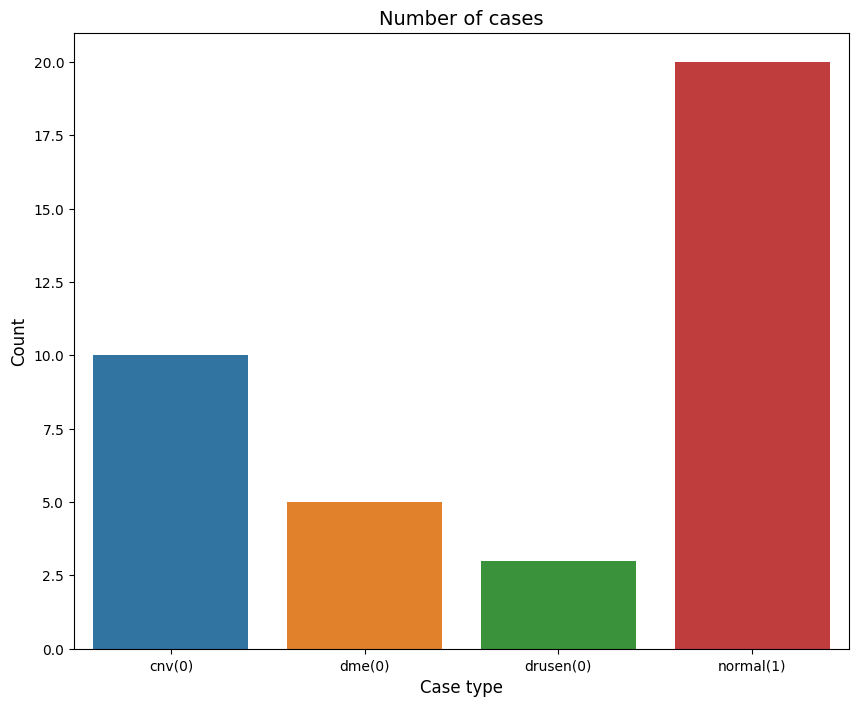

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a sample dataframe
df = pd.DataFrame({
    'label': ['cnv(0)', 'dme(0)', 'drusen(0)', 'normal(1)'],
    'value': [10, 5, 3, 20]
})

# Create a series from the dataframe
cases_count = df.set_index('label')['value']

# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), cases_count.index)
plt.show()

/content


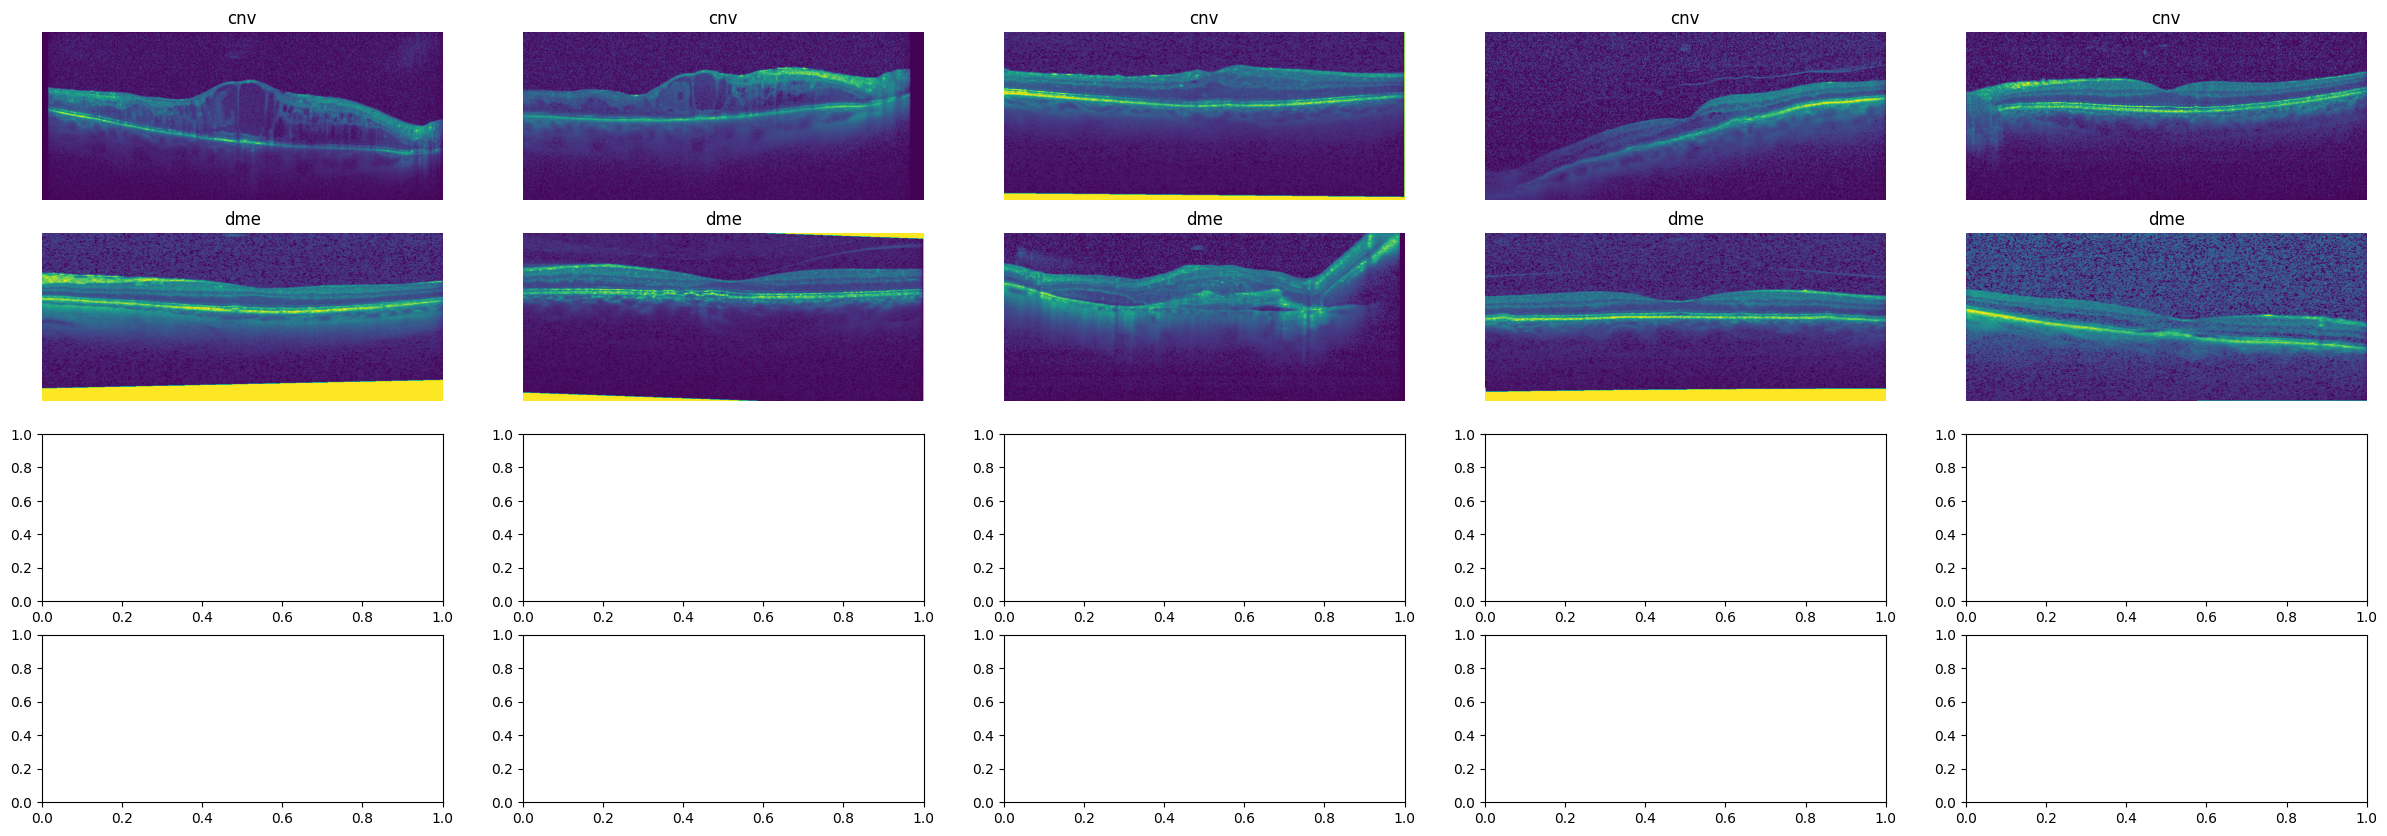

10


In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import os
print(os.getcwd())


# Get few samples for both the classes
cnv_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
dme_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
drusen_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==3]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above four lists
samples = cnv_samples + dme_samples + drusen_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(4,5, figsize=(30,10))
for i in range(10):
      img = imread(samples[i])
      ax[i//5, i%5].imshow(img, cmap=None)
      if i < 5:
        ax[i//5, i%5].set_title("cnv")
      elif i<10:
        ax[i//5, i%5].set_title("dme")
      elif i < 15:
        ax[i//5, i%5].set_title("drusen")
      else:
        ax[i//5, i%5].set_title("normal")
      ax[i//5, i%5].axis('off')
      ax[i//5, i%5].set_aspect('auto')
plt.show()

print(len(samples))

In [ ]:
from pathlib import Path

# Define the paths to the train and validation directories
base_dir = Path('/content/drive/MyDrive/OCT2017.')
train_dir = base_dir / 'Train'  
val_dir = base_dir / 'test'

# Get the path to the sub-directories
cnv_cases_dir = train_dir / '/content/drive/MyDrive/OCT2017./Train/CNV'
dme_cases_dir = train_dir / '/content/drive/MyDrive/OCT2017./Train/DME'
drusen_cases_dir = train_dir /'/content/drive/MyDrive/OCT2017./Train/DRUSEN'
normal_cases_dir = train_dir / '/content/drive/MyDrive/OCT2017./Train/NORMAL'

# Print the number of images in each sub-directory
print('CNV images:', len(list(cnv_cases_dir.glob('*.jpeg'))))
print('DME images:', len(list(dme_cases_dir.glob('*.jpeg'))))
print('DRUSEN images:', len(list(drusen_cases_dir.glob('*.jpeg'))))
print('NORMAL images:', len(list(normal_cases_dir.glob('*.jpeg'))))

# Get the list of all the images
cnv_cases = cnv_cases_dir.glob('*.jpeg')
dme_cases = dme_cases_dir.glob('*.jpeg')
drusen_cases = drusen_cases_dir.glob('*.jpeg')
normal_cases = normal_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# cnv cases
for img in cnv_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# dme cases        
for img in dme_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

    # drusen cases        
for img in drusen_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

    # normal cases        
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

CNV images: 319
DME images: 615
DRUSEN images: 200
NORMAL images: 309
Total number of validation examples:  (1443, 224, 224, 3)
Total number of labels: (1443, 2)


In [ ]:
len(valid_data)

1443

In [ ]:
len(valid_labels)

1443

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [ ]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [ ]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =  build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
# Open the VGG16 weight file
f = h5py.File('/content/drive/MyDrive/oct/vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()   

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

# Get a train data generator
train_data_gen = data_gen(train_data, batch_size)

# Define the number of training steps
nb_train_steps = valid_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 194 and 3110


In [ ]:
train_data_gen

<generator object data_gen at 0x7f25356ec200>

In [ ]:
history = model.fit_generator(
    train_data_gen, 
    epochs=nb_epochs, 
    steps_per_epoch=nb_train_steps, 
    validation_data=valid_data, 
    validation_steps=nb_validation_steps,
    callbacks=[es, chkpt], 
    class_weight={0:1.0, 1:0.4}
)


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/oct/Saved Model/model.h5')


In [ ]:
# Load the model weights
model.load_weights("/content/drive/MyDrive/oct/Saved Model/my_model.h5")


In [ ]:
# Preparing test data
val_dir =  'CNV'
val_dir =  'DME'
val_dir =  'DRUSEN'
val_dir =  'NORMAL'

# Print the number of images in each sub-directory
print('CNV images:', len(list(cnv_cases_dir.glob('*.jpeg'))))
print('DME images:', len(list(dme_cases_dir.glob('*.jpeg'))))
print('DRUSEN images:', len(list(drusen_cases_dir.glob('*.jpeg'))))
print('NORMAL images:', len(list(normal_cases_dir.glob('*.jpeg'))))

# Get the list of all the images
cnv_cases = cnv_cases_dir.glob('*.jpeg')
dme_cases = dme_cases_dir.glob('*.jpeg')
drusen_cases = drusen_cases_dir.glob('*.jpeg')
normal_cases = normal_cases_dir.glob('*.jpeg')


test_data = []
test_labels = []

for img in cnv_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in dme_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in drusen_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

CNV images: 1825
DME images: 615
DRUSEN images: 361
NORMAL images: 309
Total number of test examples:  (3110, 224, 224, 3)
Total number of labels: (3110, 2)


In [ ]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Loss on test set:  0.4468465655562962
Accuracy on test set:  0.8501608


In [ ]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(3110,)
(3110,)


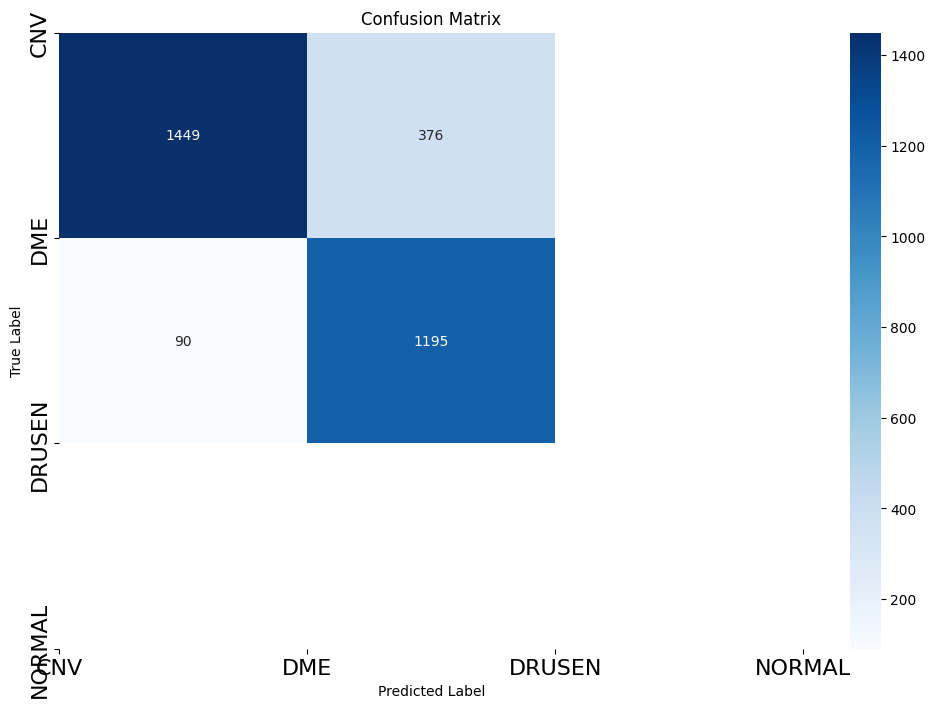

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(orig_test_labels, preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks(range(4), ['CNV', 'DME', 'DRUSEN', 'NORMAL'], fontsize=16)
plt.yticks(range(4), ['CNV', 'DME', 'DRUSEN', 'NORMAL'], fontsize=16)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.93
Precision of the model is 0.76
